# Scenario 3
For scenario 3, from the description: "Explore the space of closely related models (structurally speaking) that incorporate either deaths, hospitalizations, or both.". For this purpose, models 958 and 960 are relevant.

In [44]:
from mira.modeling import Model
from mira.modeling.petri import PetriNetModel
from mira.sources.biomodels import get_template_model
from mira.metamodel import TemplateModelDelta, ControlledConversion
from mira.dkg.web_client import is_ontological_child_web
from mira.metamodel.ops import simplify_rate_laws

In [45]:
# Get models 958 and 960
model_958 = simplify_rate_laws(get_template_model("BIOMD0000000958"))
model_960 = simplify_rate_laws(get_template_model("BIOMD0000000960"))

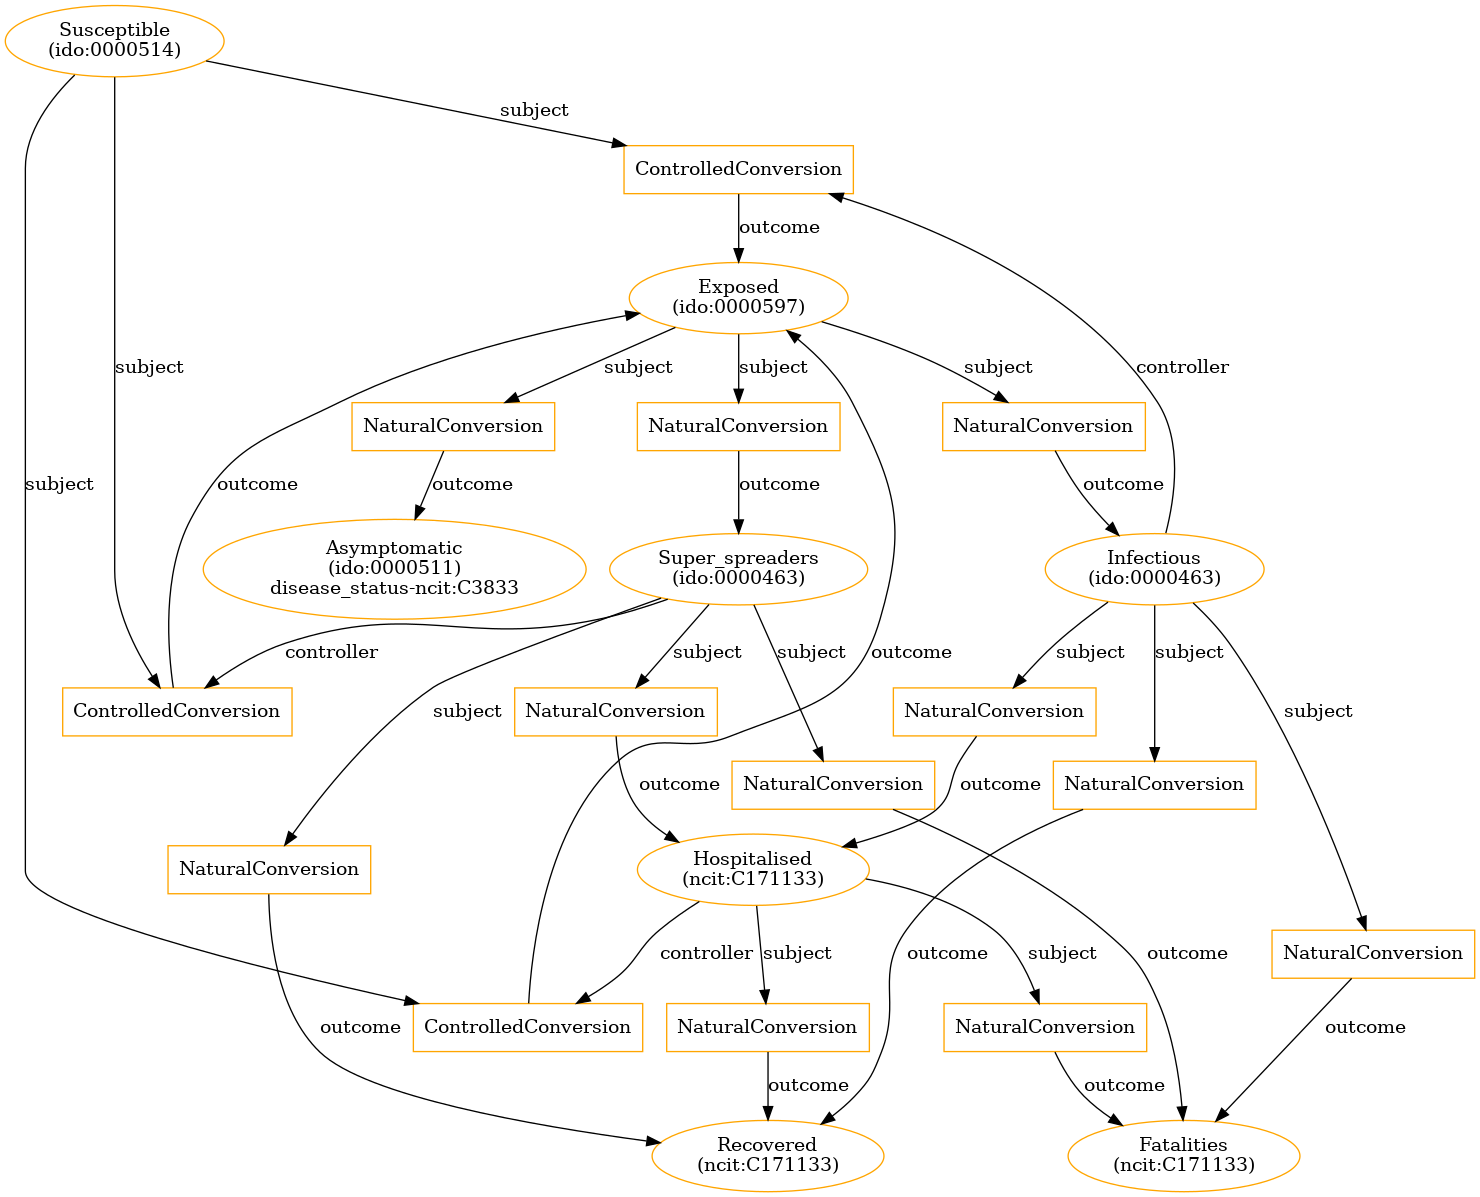

In [46]:
# Check out the models
from IPython.display import Image
model_958.draw_graph("scenario3_model_958.png")
Image(filename="scenario3_model_958.png", width='50%')

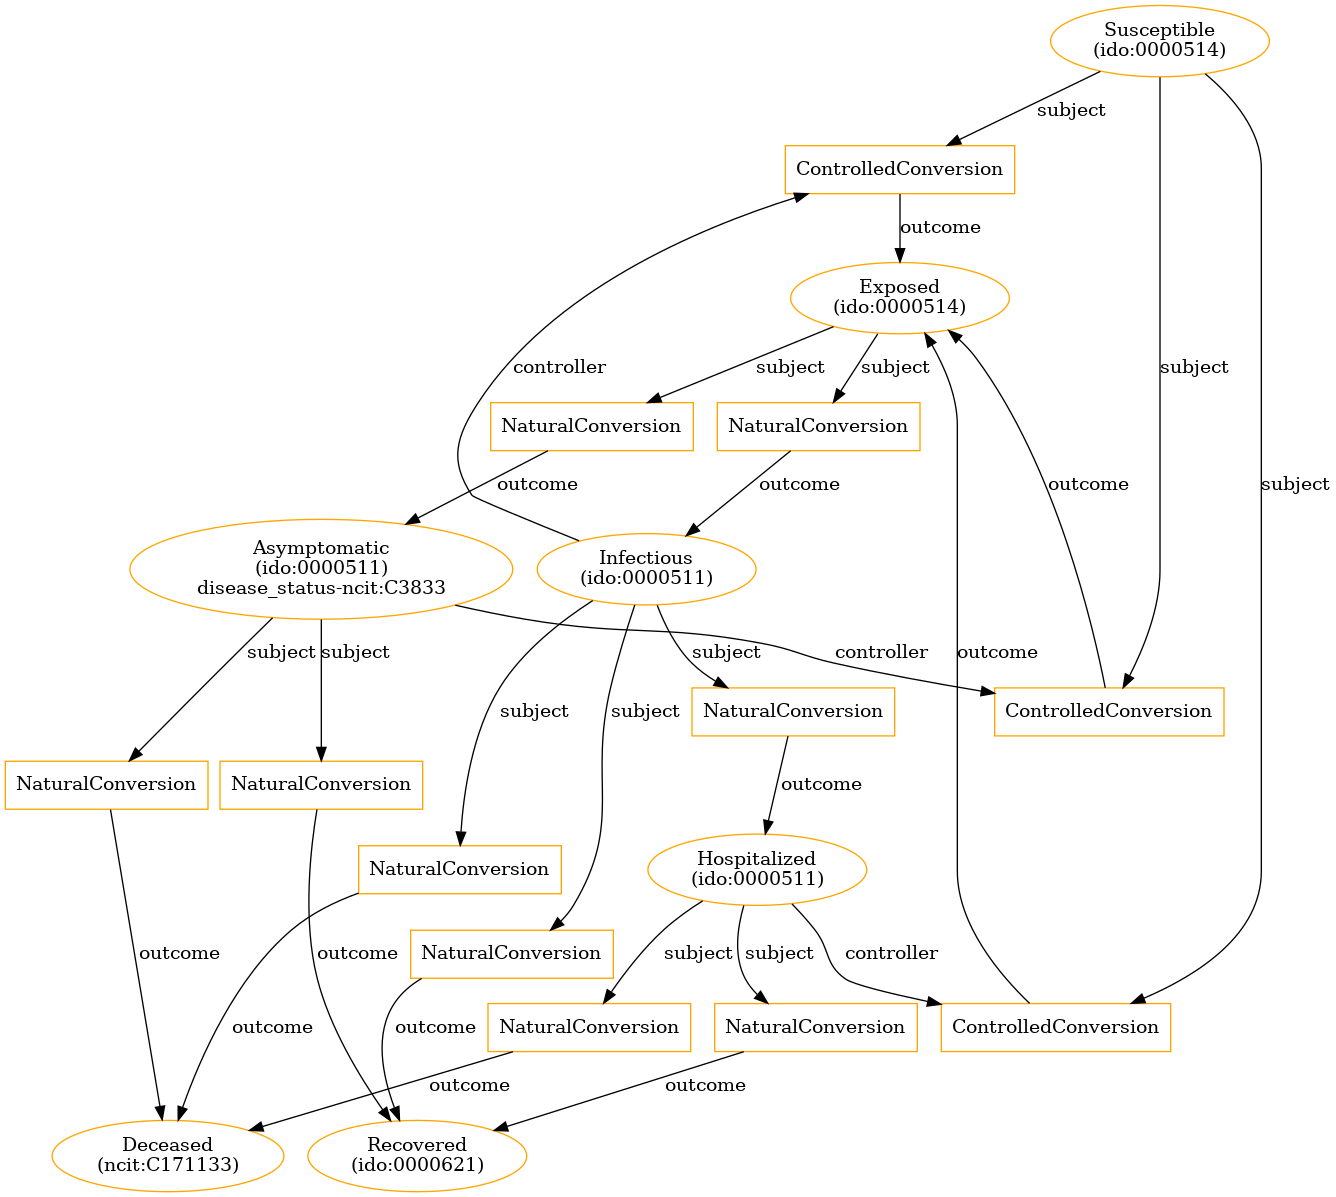

In [47]:
model_960.draw_graph("scenario3_model_960.png")
Image(filename="scenario3_model_960.png", width='50%')

## Human in the loop improvements
As can be seen in the output above, several concepts have vague identification and need to be better annotated in order to disambiguate them. The human in the loop intervention needed is "simulated" by the following mapping:

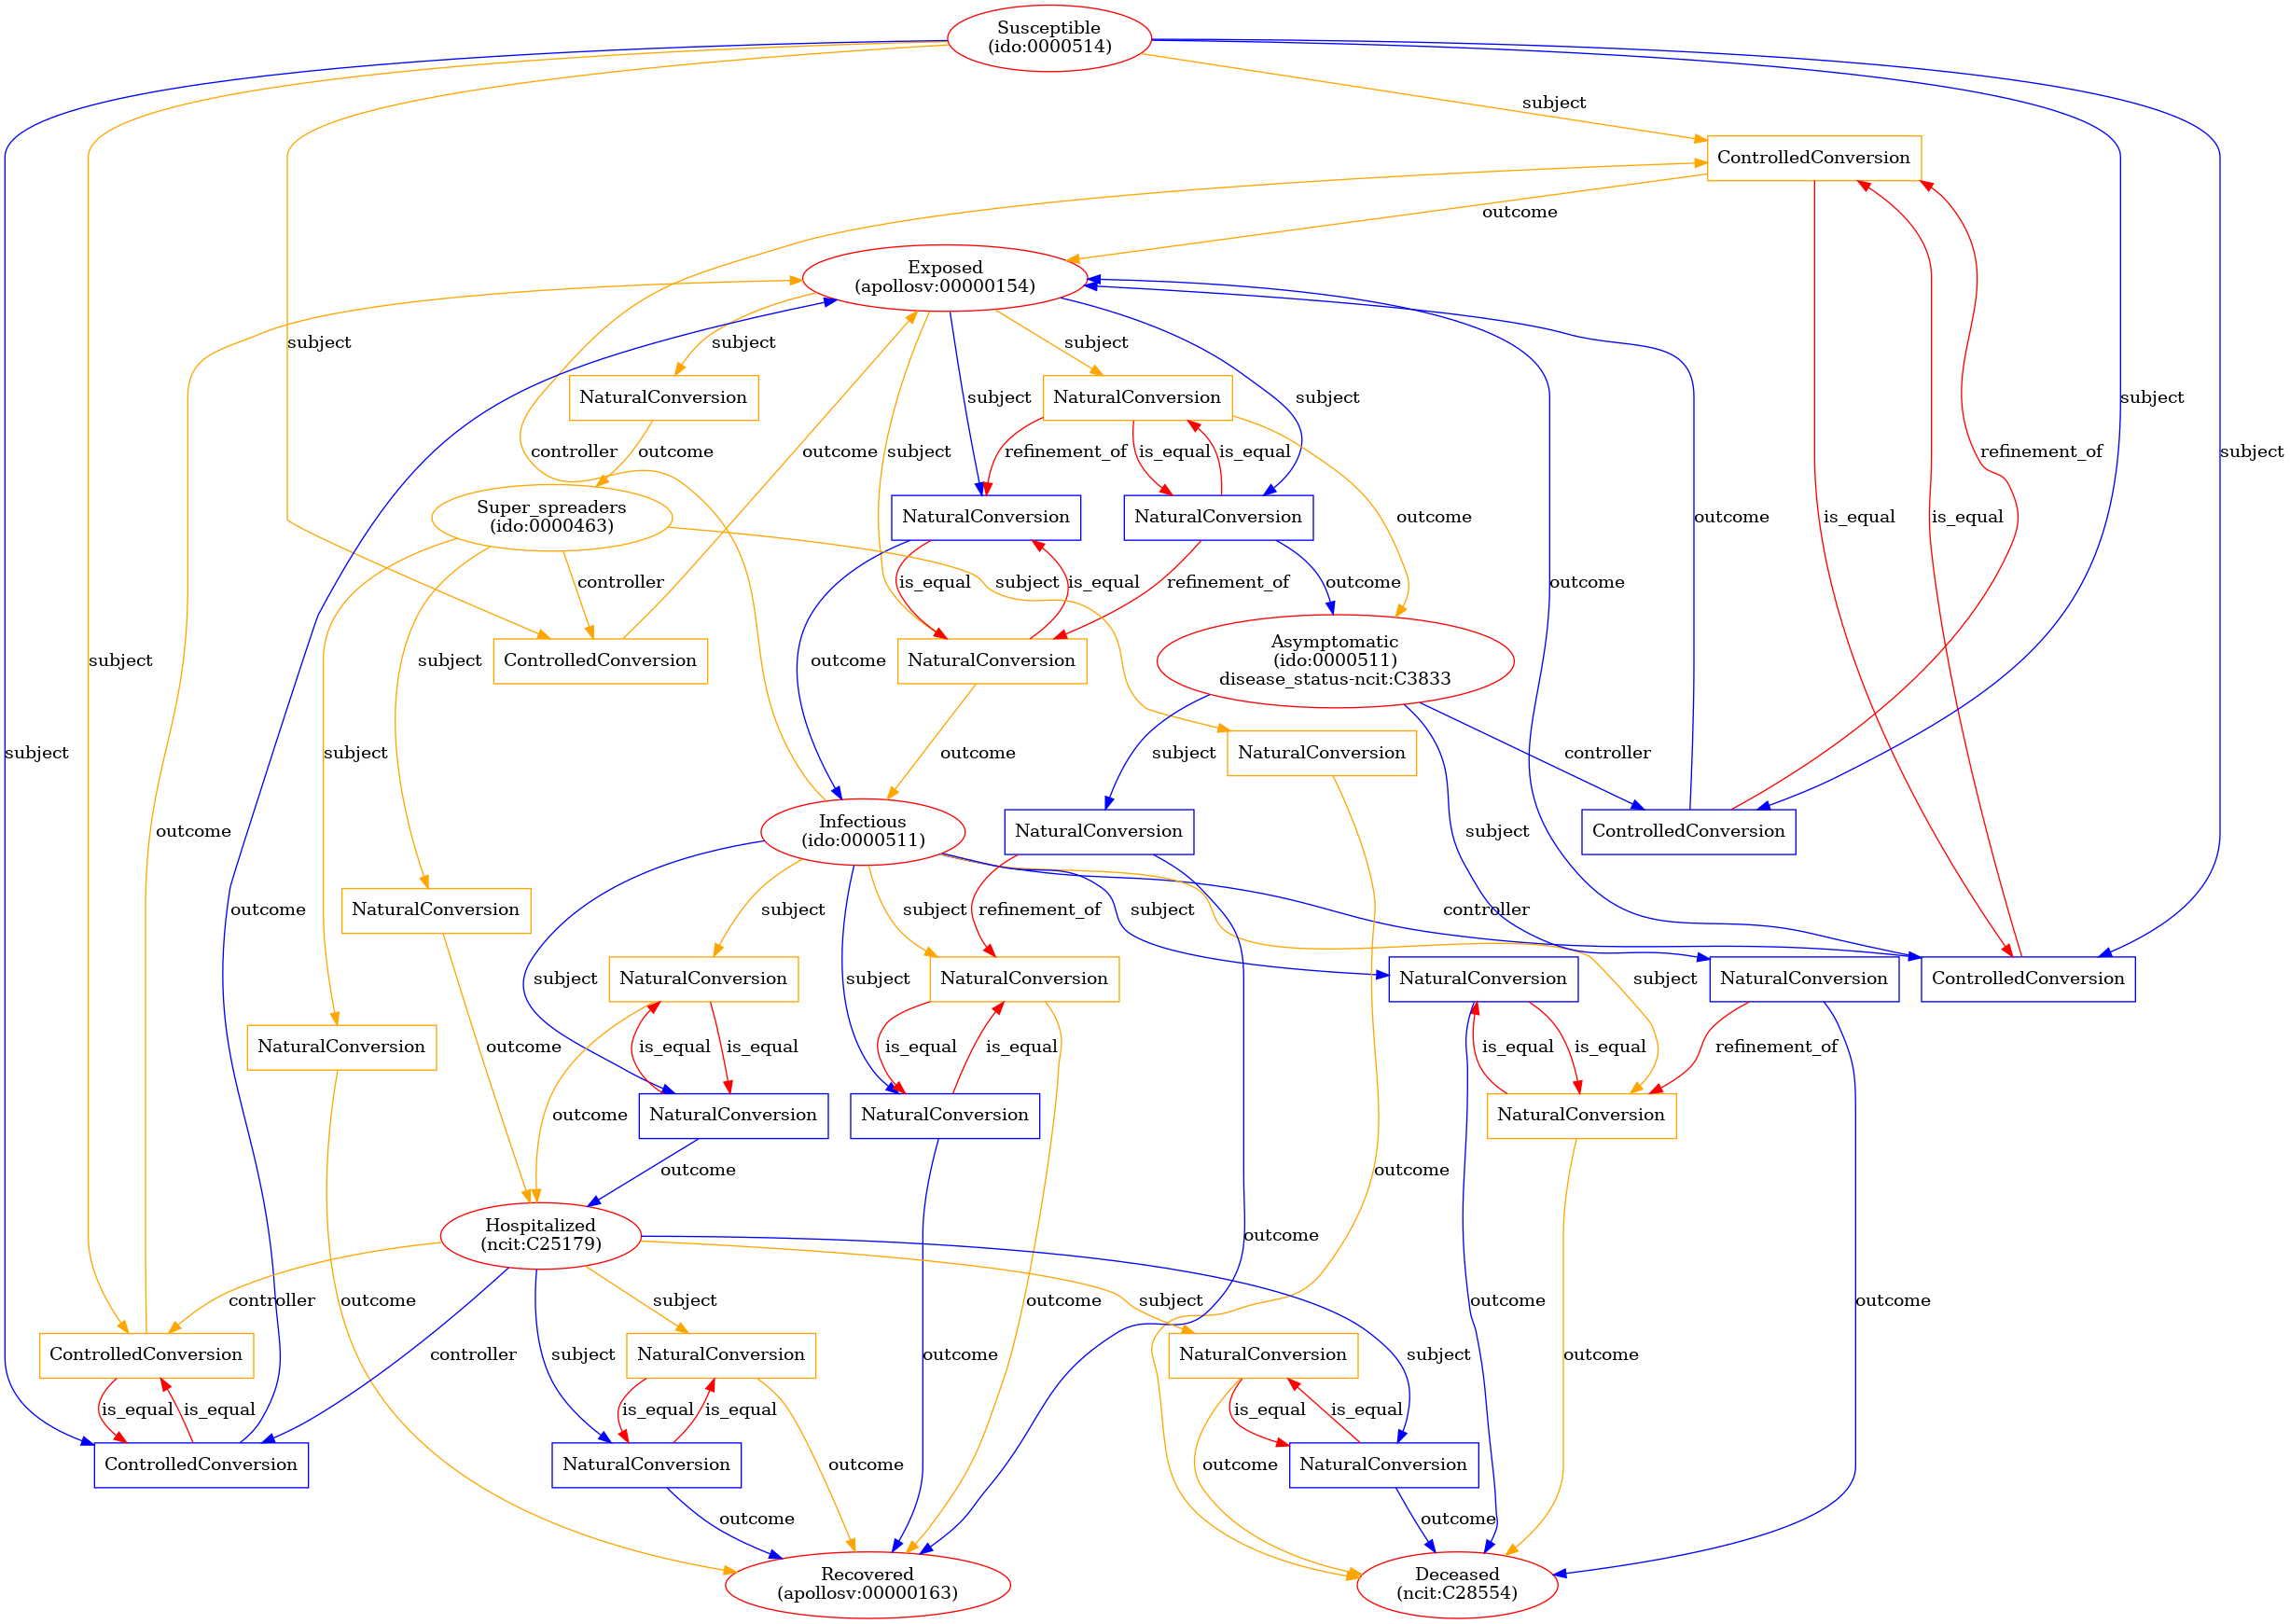

In [48]:
from mira.metamodel import Concept

# Identifiers seen here:
# ncit:C171133 (covid-19 infection) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C171133
# ncit:C28554 (death) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C28554
# ncit:C25179 (hospitalization) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C25179
# apollosv:00000163 (Recoverd Population) https://ontobee.org/ontology/APOLLO_SV?iri=http://purl.obolibrary.org/obo/APOLLO_SV_00000163
# ido:0000511 (infected population) https://www.ebi.ac.uk/ols/ontologies/ido/terms?obo_id=IDO:0000511
# ido:0000514 (susceptible population) https://www.ebi.ac.uk/ols/ontologies/ido/terms?obo_id=IDO:0000514

concept_mapping = {
    "958": {
        "Exposed": Concept(name="Exposed",
                           identifiers={"apollosv": "00000154"}),
        "Infectious": Concept(name="Infectious",
                              identifiers={"ido": "0000511", "apollosv": "00000163"}),
        "Fatalities": Concept(name="Fatalities",
                              identifiers={"ncit": "C28554"}),
        "Hospitalised": Concept(name="Hospitalised",
                                identifiers={"ncit": "C25179"}),
        "Recovered": Concept(name="Recovered",
                             identifiers={"apollosv": "00000163"}),
    },
    "960": {
        "Exposed": Concept(name="Exposed",
                           identifiers={"apollosv": "00000154"}),
        "Deceased": Concept(name="Deceased",
                            identifiers={"ncit": "C28554"}),
        "Infectious": Concept(name="Infectious",
                              identifiers={"ido": "0000511", "apollosv": "00000163"}),
        "Hospitalized": Concept(name="Hospitalized",
                                identifiers={"ncit": "C25179"}),
        "Recovered": Concept(name="Recovered",
                             identifiers={"apollosv": "00000163"}),
    }
}

# Map the concepts from previous
for template_958 in model_958.templates:
    for concept in template_958.get_concepts():
        if concept.name in concept_mapping["958"]:
            concept.identifiers = concept_mapping["958"][concept.name].identifiers

for template_960 in model_960.templates:
    for concept in template_960.get_concepts():
        if concept.name in concept_mapping["960"]:
            concept.identifiers = concept_mapping["960"][concept.name].identifiers

# Now do the comparison
tmd_corr = TemplateModelDelta(model_958, model_960, refinement_function=is_ontological_child_web)
tmd_corr.draw_graph("scenario3_model_958_960_delta_corrected.png", args="-Grankdir=TB")
Image(filename="scenario3_model_958_960_delta_corrected.png")

In [49]:
petri_958 = PetriNetModel(Model(model_958))
petri_960 = PetriNetModel(Model(model_960))
for mname, model in [("scenario3_biomd958.json", petri_958), ("scenario3_biomd960.json", petri_960)]:
    model.to_json_file(mname, indent=1)
# Also dump the mira model jsons
with open("scenario3_biomd958_mira.json", "w") as f:
    f.write(model_958.json(indent=1))
with open("scenario3_biomd960_mira.json", "w") as f:
    f.write(model_960.json(indent=1))

In [50]:
# Simplify rate laws and make new Petri net model
from mira.metamodel.ops import simplify_rate_laws, aggregate_parameters
for mname, model in [("scenario3_biomd958_rate_law_subs.json", model_958),
                     ("scenario3_biomd960_rate_law_subs.json", model_960)]:
    model2 = aggregate_parameters(simplify_rate_laws(model))
    pm = PetriNetModel(Model(model2))
    pm.to_json_file(mname, indent=1)

## Add vaccination
We now need to add vaccination to the two models

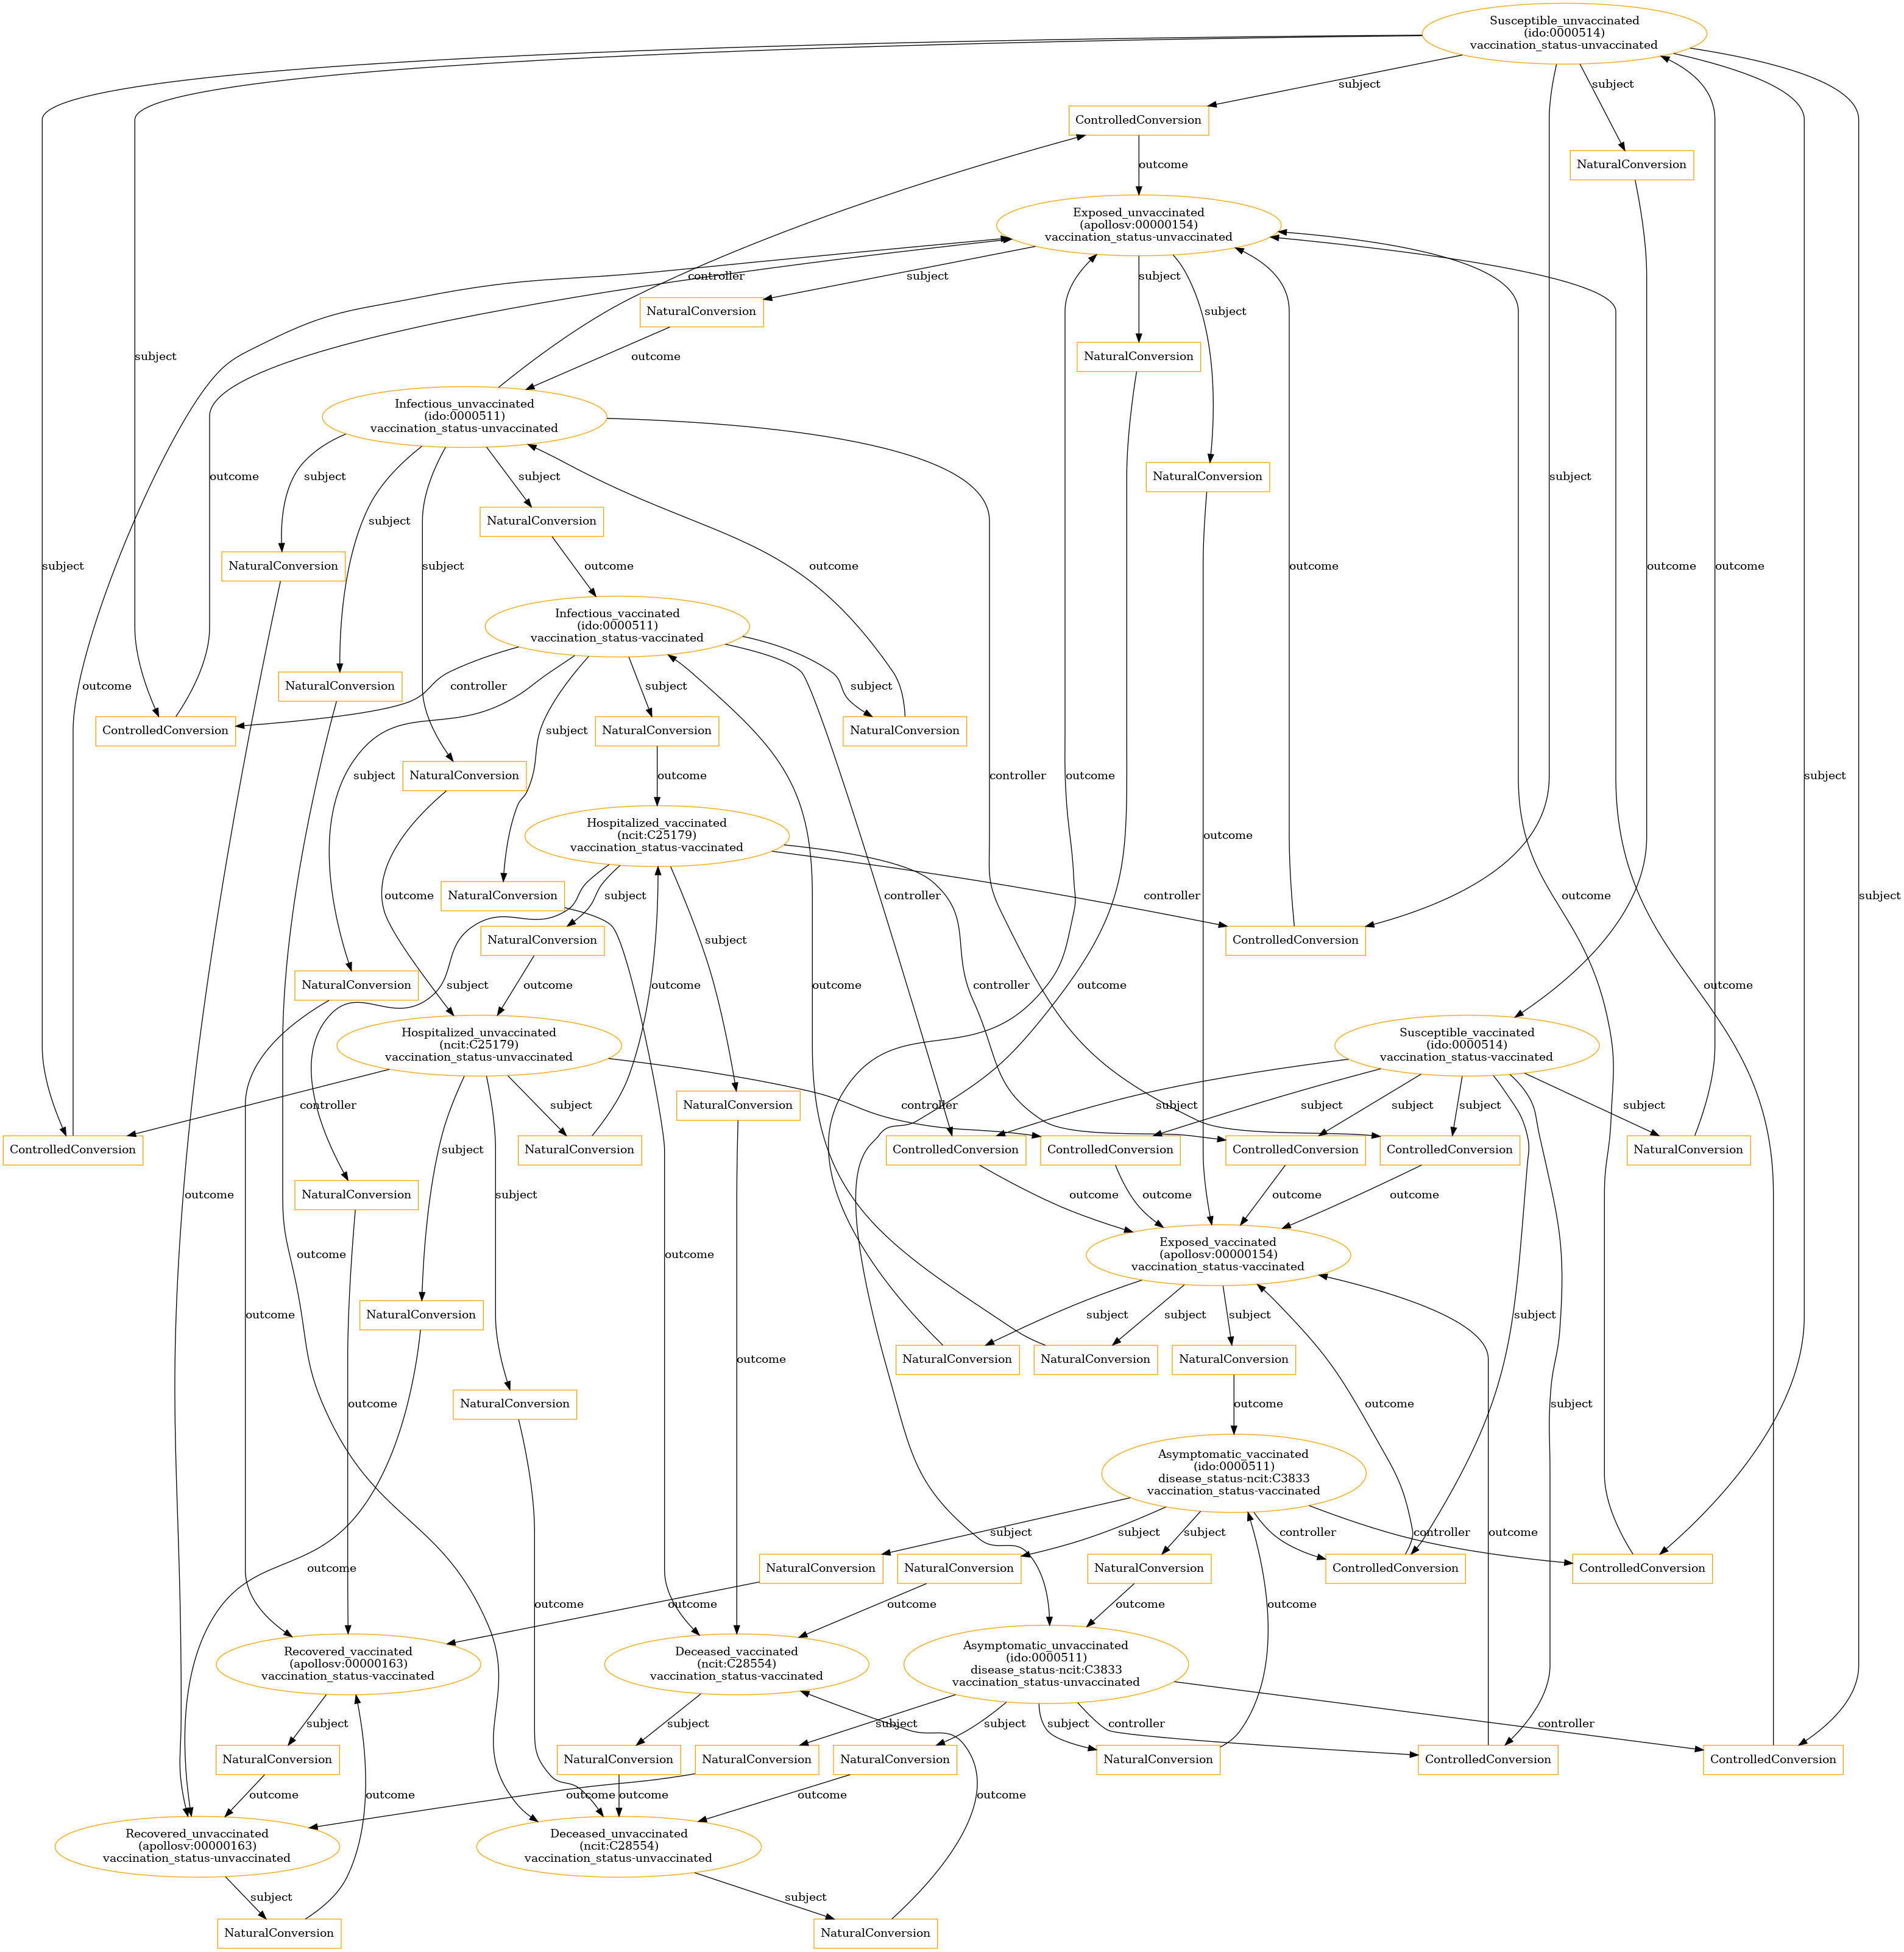

In [51]:
from mira.metamodel.ops import stratify

model_958_vaccination = stratify(model_958, key="vaccination_status", strata={"vaccinated", "unvaccinated"}, directed=False, cartesian_control=True, modify_names=True)
model_958_vaccination.draw_graph("scenario3_model_958_vaccination.png")
Image(filename="scenario3_model_958_vaccination.png")
model_960_vaccination = stratify(model_960, key="vaccination_status", strata={"vaccinated", "unvaccinated"}, directed=False, cartesian_control=True, modify_names=True)
model_960_vaccination.draw_graph("scenario3_model_960_vaccination.png")
Image(filename="scenario3_model_960_vaccination.png")

## Add reinfection
We're asked to add reinfection to the model. This is done by adding one transition per each infectious node using ControlledConversion with `recovered` as subject, `exposed` as outcome and the infectious node as controller.

In [52]:
# Get the recovered and infected nodes from each model
for ix, templ in enumerate(model_958_vaccination.templates):
    print(ix)
    print(templ.type)
    if templ.rate_law is None:
        print("((No rate law))")
    else:
        print(templ.rate_law)
    print(templ.outcome)
    print('---')

0
ControlledConversion
Infectious_unvaccinated*Susceptible_unvaccinated*beta/N
name='Exposed_unvaccinated' identifiers={'apollosv': '00000154'} context={'vaccination_status': 'unvaccinated'}
---
1
ControlledConversion
Infectious_vaccinated*Susceptible_unvaccinated*beta/N
name='Exposed_unvaccinated' identifiers={'apollosv': '00000154'} context={'vaccination_status': 'unvaccinated'}
---
2
ControlledConversion
Infectious_vaccinated*Susceptible_vaccinated*beta/N
name='Exposed_vaccinated' identifiers={'apollosv': '00000154'} context={'vaccination_status': 'vaccinated'}
---
3
ControlledConversion
Infectious_unvaccinated*Susceptible_vaccinated*beta/N
name='Exposed_vaccinated' identifiers={'apollosv': '00000154'} context={'vaccination_status': 'vaccinated'}
---
4
ControlledConversion
Hospitalised_unvaccinated*Susceptible_unvaccinated*beta*l/N
name='Exposed_unvaccinated' identifiers={'apollosv': '00000154'} context={'vaccination_status': 'unvaccinated'}
---
5
ControlledConversion
Hospitalised_v

In [53]:
exposed_958_unvaccinated = model_958_vaccination.templates[1].outcome
exposed_958_vaccinated = model_958_vaccination.templates[2].outcome
superspreaders_958_unvaccinated = model_958_vaccination.templates[14].outcome
superspreaders_958_vaccinated = model_958_vaccination.templates[15].outcome
asymptomatic_958_unvaccinated = model_958_vaccination.templates[12].outcome
asymptomatic_958_vaccinated = model_958_vaccination.templates[13].outcome
recovered_958_unvaccinated = model_958_vaccination.templates[22].outcome
recovered_958_vaccinated = model_958_vaccination.templates[23].outcome
infected_958_vaccinated = model_958_vaccination.templates[38].outcome
infected_958_unvaccinated = model_958_vaccination.templates[39].outcome

# Create the transitions, add the rate laws (for all transitions), and add them to the models. Add one ControlledConversion per vaccination status per infectious node.

# 1. Unvaccinated reinfection by unvaccinated infectious
reinfection_958_unvaccinated_1 = ControlledConversion(
    subject=recovered_958_unvaccinated,
    controller=infected_958_unvaccinated,
    outcome=exposed_958_unvaccinated)
reinfection_958_unvaccinated_1.set_mass_action_rate_law("reinfection_rate_unvaccinated_1")

# 2. Unvaccinated reinfection by vaccinated infectious
reinfection_958_unvaccinated_2 = ControlledConversion(
    subject=recovered_958_unvaccinated,
    controller=infected_958_vaccinated,
    outcome=exposed_958_unvaccinated)
reinfection_958_unvaccinated_2.set_mass_action_rate_law("reinfection_rate_unvaccinated_2")

# 3. Unvaccinated reinfection by unvaccinated superspreaders
reinfection_958_unvaccinated_3 = ControlledConversion(
    subject=recovered_958_unvaccinated,
    controller=superspreaders_958_unvaccinated,
    outcome=exposed_958_unvaccinated)
reinfection_958_unvaccinated_3.set_mass_action_rate_law("reinfection_rate_unvaccinated_3")

# 4. Unvaccinated reinfection by vaccinated superspreaders
reinfection_958_unvaccinated_4 = ControlledConversion(
    subject=recovered_958_unvaccinated,
    controller=superspreaders_958_vaccinated,
    outcome=exposed_958_unvaccinated)
reinfection_958_unvaccinated_4.set_mass_action_rate_law("reinfection_rate_unvaccinated_4")

# 5. Unvaccinated reinfection by unvaccinated asymptomatic
reinfection_958_unvaccinated_5 = ControlledConversion(
    subject=recovered_958_unvaccinated,
    controller=asymptomatic_958_unvaccinated,
    outcome=exposed_958_unvaccinated)
reinfection_958_unvaccinated_5.set_mass_action_rate_law("reinfection_rate_unvaccinated_5")

# 6. Unvaccinated reinfection by vaccinated asymptomatic
reinfection_958_unvaccinated_6 = ControlledConversion(
    subject=recovered_958_unvaccinated,
    controller=asymptomatic_958_vaccinated,
    outcome=exposed_958_unvaccinated)
reinfection_958_unvaccinated_6.set_mass_action_rate_law("reinfection_rate_unvaccinated_6")

# Vaccinated reinfections
# 7. Vaccinated reinfection by unvaccinated infectious
reinfection_958_vaccinated_1 = ControlledConversion(
    subject=recovered_958_vaccinated,
    controller=infected_958_unvaccinated,
    outcome=exposed_958_vaccinated)
reinfection_958_vaccinated_1.set_mass_action_rate_law("reinfection_rate_vaccinated_1")

# 8. Vaccinated reinfection by vaccinated infectious
reinfection_958_vaccinated_2 = ControlledConversion(
    subject=recovered_958_vaccinated,
    controller=infected_958_vaccinated,
    outcome=exposed_958_vaccinated)
reinfection_958_vaccinated_2.set_mass_action_rate_law("reinfection_rate_vaccinated_2")

# 9. Vaccinated reinfection by unvaccinated superspreaders
reinfection_958_vaccinated_3 = ControlledConversion(
    subject=recovered_958_vaccinated,
    controller=superspreaders_958_unvaccinated,
    outcome=exposed_958_vaccinated)
reinfection_958_vaccinated_3.set_mass_action_rate_law("reinfection_rate_vaccinated_3")

# 10. Vaccinated reinfection by vaccinated superspreaders
reinfection_958_vaccinated_4 = ControlledConversion(
    subject=recovered_958_vaccinated,
    controller=superspreaders_958_vaccinated,
    outcome=exposed_958_vaccinated)
reinfection_958_vaccinated_4.set_mass_action_rate_law("reinfection_rate_vaccinated_4")

# 11. Vaccinated reinfection by unvaccinated asymptomatic
reinfection_958_vaccinated_5 = ControlledConversion(
    subject=recovered_958_vaccinated,
    controller=asymptomatic_958_unvaccinated,
    outcome=exposed_958_vaccinated)
reinfection_958_vaccinated_5.set_mass_action_rate_law("reinfection_rate_vaccinated_5")

# 12. Vaccinated reinfection by vaccinated asymptomatic
reinfection_958_vaccinated_6 = ControlledConversion(
    subject=recovered_958_vaccinated,
    controller=asymptomatic_958_vaccinated,
    outcome=exposed_958_vaccinated)
reinfection_958_vaccinated_6.set_mass_action_rate_law("reinfection_rate_vaccinated_6")

from mira.metamodel import Parameter, TemplateModel

# Extend model 958
model_958_vaccination_reinfection = model_958_vaccination.extend(
    template_model=TemplateModel(
        templates=[reinfection_958_unvaccinated_1, reinfection_958_unvaccinated_2,
                   reinfection_958_unvaccinated_3, reinfection_958_unvaccinated_4,
                   reinfection_958_unvaccinated_5, reinfection_958_unvaccinated_6,
                   reinfection_958_vaccinated_1, reinfection_958_vaccinated_2,
                   reinfection_958_vaccinated_3, reinfection_958_vaccinated_4,
                   reinfection_958_vaccinated_5, reinfection_958_vaccinated_6],
        parameters={
            "reinfection_rate_unvaccinated_1": Parameter(name="reinfection_rate_unvaccinated_1", value=1),
            "reinfection_rate_unvaccinated_2": Parameter(name="reinfection_rate_unvaccinated_2", value=1),
            "reinfection_rate_unvaccinated_3": Parameter(name="reinfection_rate_unvaccinated_3", value=1),
            "reinfection_rate_unvaccinated_4": Parameter(name="reinfection_rate_unvaccinated_4", value=1),
            "reinfection_rate_unvaccinated_5": Parameter(name="reinfection_rate_unvaccinated_5", value=1),
            "reinfection_rate_unvaccinated_6": Parameter(name="reinfection_rate_unvaccinated_6", value=1),
            "reinfection_rate_vaccinated_1": Parameter(name="reinfection_rate_vaccinated_1", value=1),
            "reinfection_rate_vaccinated_2": Parameter(name="reinfection_rate_vaccinated_2", value=1),
            "reinfection_rate_vaccinated_3": Parameter(name="reinfection_rate_vaccinated_3", value=1),
            "reinfection_rate_vaccinated_4": Parameter(name="reinfection_rate_vaccinated_4", value=1),
            "reinfection_rate_vaccinated_5": Parameter(name="reinfection_rate_vaccinated_5", value=1),
            "reinfection_rate_vaccinated_6": Parameter(name="reinfection_rate_vaccinated_6", value=1),
        },
    )
)

# Check the templates for the 960 model
for ix, templ in enumerate(model_960_vaccination.templates):
    print(ix)
    print(templ.type)
    if templ.rate_law is None:
        print("((No rate law))")
    else:
        print(templ.rate_law)
    print(templ.outcome)
    print('---')

0
ControlledConversion
Infectious_unvaccinated*Susceptible_unvaccinated*(ModelValue_0*beta_1_China + ModelValue_1*beta_1_Italy + ModelValue_2*beta_1_Spain + ModelValue_3*beta_1_France + ModelValue_4*beta_1_Germany + ModelValue_5*beta_1_USA)/(ModelValue_0*ModelValue_130 + ModelValue_1*ModelValue_131 + ModelValue_132*ModelValue_2 + ModelValue_133*ModelValue_3 + ModelValue_134*ModelValue_4 + ModelValue_135*ModelValue_5)
name='Exposed_unvaccinated' identifiers={'apollosv': '00000154'} context={'vaccination_status': 'unvaccinated'}
---
1
ControlledConversion
Infectious_vaccinated*Susceptible_unvaccinated*(ModelValue_0*beta_1_China + ModelValue_1*beta_1_Italy + ModelValue_2*beta_1_Spain + ModelValue_3*beta_1_France + ModelValue_4*beta_1_Germany + ModelValue_5*beta_1_USA)/(ModelValue_0*ModelValue_130 + ModelValue_1*ModelValue_131 + ModelValue_132*ModelValue_2 + ModelValue_133*ModelValue_3 + ModelValue_134*ModelValue_4 + ModelValue_135*ModelValue_5)
name='Exposed_unvaccinated' identifiers={'ap

In [54]:
asymptomatic_960_unvaccinated = model_960_vaccination.templates[37].outcome
asymptomatic_960_vaccinated = model_960_vaccination.templates[36].outcome
exposed_960_unvaccinated = model_960_vaccination.templates[0].outcome
exposed_960_vaccinated = model_960_vaccination.templates[2].outcome
recovered_960_unvaccinated = model_960_vaccination.templates[18].outcome
recovered_960_vaccinated = model_960_vaccination.templates[19].outcome
infected_960_vaccinated = model_960_vaccination.templates[12].outcome
infected_960_unvaccinated = model_960_vaccination.templates[13].outcome

# Create the transitions, add the rate laws (for all transitions), and add them to the models
# Unvaccinated reinfection by unvaccinated infected
reinfection_960_unvaccinated_1 = ControlledConversion(
    subject=recovered_960_unvaccinated,
    controller=infected_960_unvaccinated,
    outcome=exposed_960_unvaccinated)
reinfection_960_unvaccinated_1.set_mass_action_rate_law("reinfection_rate_unvaccinated_1")

# Unvaccinated reinfection by vaccinated infected
reinfection_960_unvaccinated_2 = ControlledConversion(
    subject=recovered_960_unvaccinated,
    controller=infected_960_vaccinated,
    outcome=exposed_960_unvaccinated)
reinfection_960_unvaccinated_2.set_mass_action_rate_law("reinfection_rate_unvaccinated_2")

# Unvaccinated reinfection by unvaccinated asymptomatic
reinfection_960_unvaccinated_3 = ControlledConversion(
    subject=recovered_960_unvaccinated,
    controller=asymptomatic_960_unvaccinated,
    outcome=exposed_960_unvaccinated)
reinfection_960_unvaccinated_3.set_mass_action_rate_law("reinfection_rate_unvaccinated_3")

# Unvaccinated reinfection by vaccinated asymptomatic
reinfection_960_unvaccinated_4 = ControlledConversion(
    subject=recovered_960_unvaccinated,
    controller=asymptomatic_960_vaccinated,
    outcome=exposed_960_unvaccinated)
reinfection_960_unvaccinated_4.set_mass_action_rate_law("reinfection_rate_unvaccinated_4")

# Vaccinated reinfection by unvaccinated infected
reinfection_960_vaccinated_1 = ControlledConversion(
    subject=recovered_960_vaccinated,
    controller=infected_960_unvaccinated,
    outcome=exposed_960_vaccinated)
reinfection_960_vaccinated_1.set_mass_action_rate_law("reinfection_rate_vaccinated_1")

# Vaccinated reinfection by vaccinated infected
reinfection_960_vaccinated_2 = ControlledConversion(
    subject=recovered_960_vaccinated,
    controller=infected_960_vaccinated,
    outcome=exposed_960_vaccinated)
reinfection_960_vaccinated_2.set_mass_action_rate_law("reinfection_rate_vaccinated_2")

# Vaccinated reinfection by unvaccinated asymptomatic
reinfection_960_vaccinated_3 = ControlledConversion(
    subject=recovered_960_vaccinated,
    controller=asymptomatic_960_unvaccinated,
    outcome=exposed_960_vaccinated)
reinfection_960_vaccinated_3.set_mass_action_rate_law("reinfection_rate_vaccinated_3")

# Vaccinated reinfection by vaccinated asymptomatic
reinfection_960_vaccinated_4 = ControlledConversion(
    subject=recovered_960_vaccinated,
    controller=asymptomatic_960_vaccinated,
    outcome=exposed_960_vaccinated)
reinfection_960_vaccinated_4.set_mass_action_rate_law("reinfection_rate_vaccinated_4")

# Extend model 960
model_960_vaccination_reinfection = model_960_vaccination.extend(
    template_model=TemplateModel(
        templates=[reinfection_960_unvaccinated_1, reinfection_960_unvaccinated_2,
                   reinfection_960_unvaccinated_3, reinfection_960_unvaccinated_4,
                   reinfection_960_vaccinated_1, reinfection_960_vaccinated_2,
                   reinfection_960_vaccinated_3, reinfection_960_vaccinated_4],
        parameters={
            "reinfection_rate_unvaccinated_1": Parameter(name="reinfection_rate_unvaccinated_1", value=1),
            "reinfection_rate_unvaccinated_2": Parameter(name="reinfection_rate_unvaccinated_2", value=1),
            "reinfection_rate_unvaccinated_3": Parameter(name="reinfection_rate_unvaccinated_3", value=1),
            "reinfection_rate_unvaccinated_4": Parameter(name="reinfection_rate_unvaccinated_4", value=1),
            "reinfection_rate_vaccinated_1": Parameter(name="reinfection_rate_vaccinated_1", value=1),
            "reinfection_rate_vaccinated_2": Parameter(name="reinfection_rate_vaccinated_2", value=1),
            "reinfection_rate_vaccinated_3": Parameter(name="reinfection_rate_vaccinated_3", value=1),
            "reinfection_rate_vaccinated_4": Parameter(name="reinfection_rate_vaccinated_4", value=1),
        },
    )
)

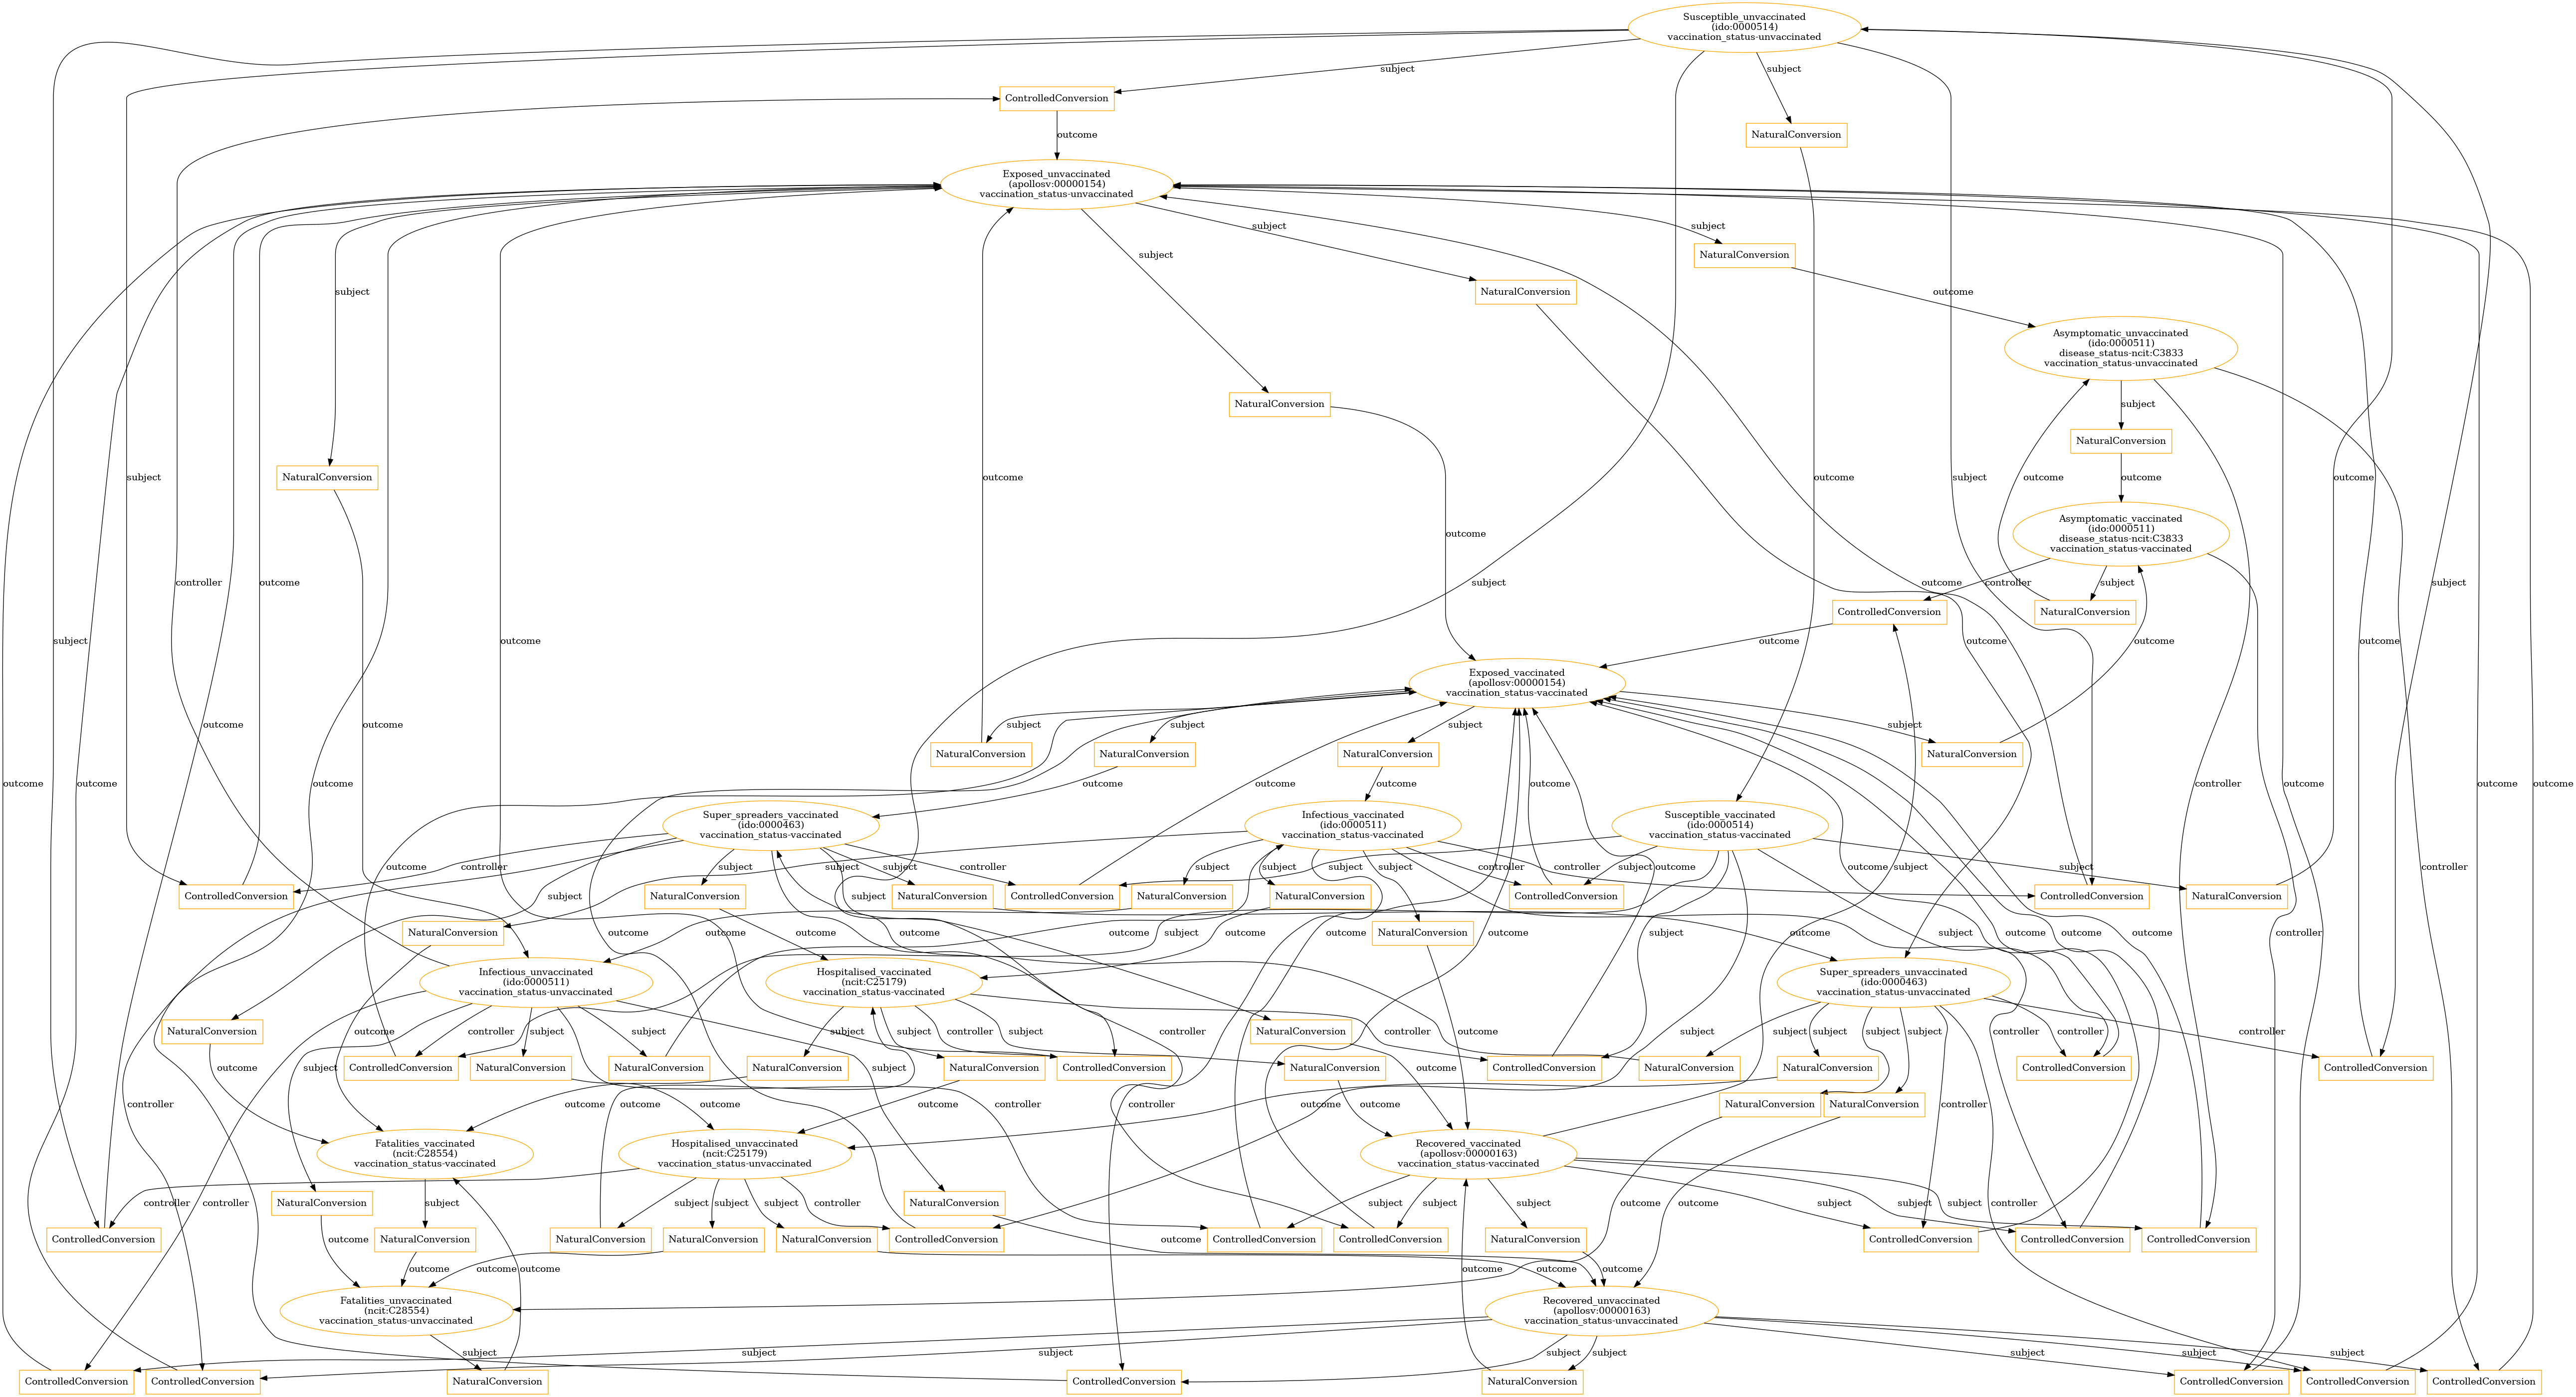

In [55]:
# Check out the models
model_958_vaccination_reinfection.draw_graph("scenario3_model_958_vaccination_reinfection.png")
Image(filename="scenario3_model_958_vaccination_reinfection.png")

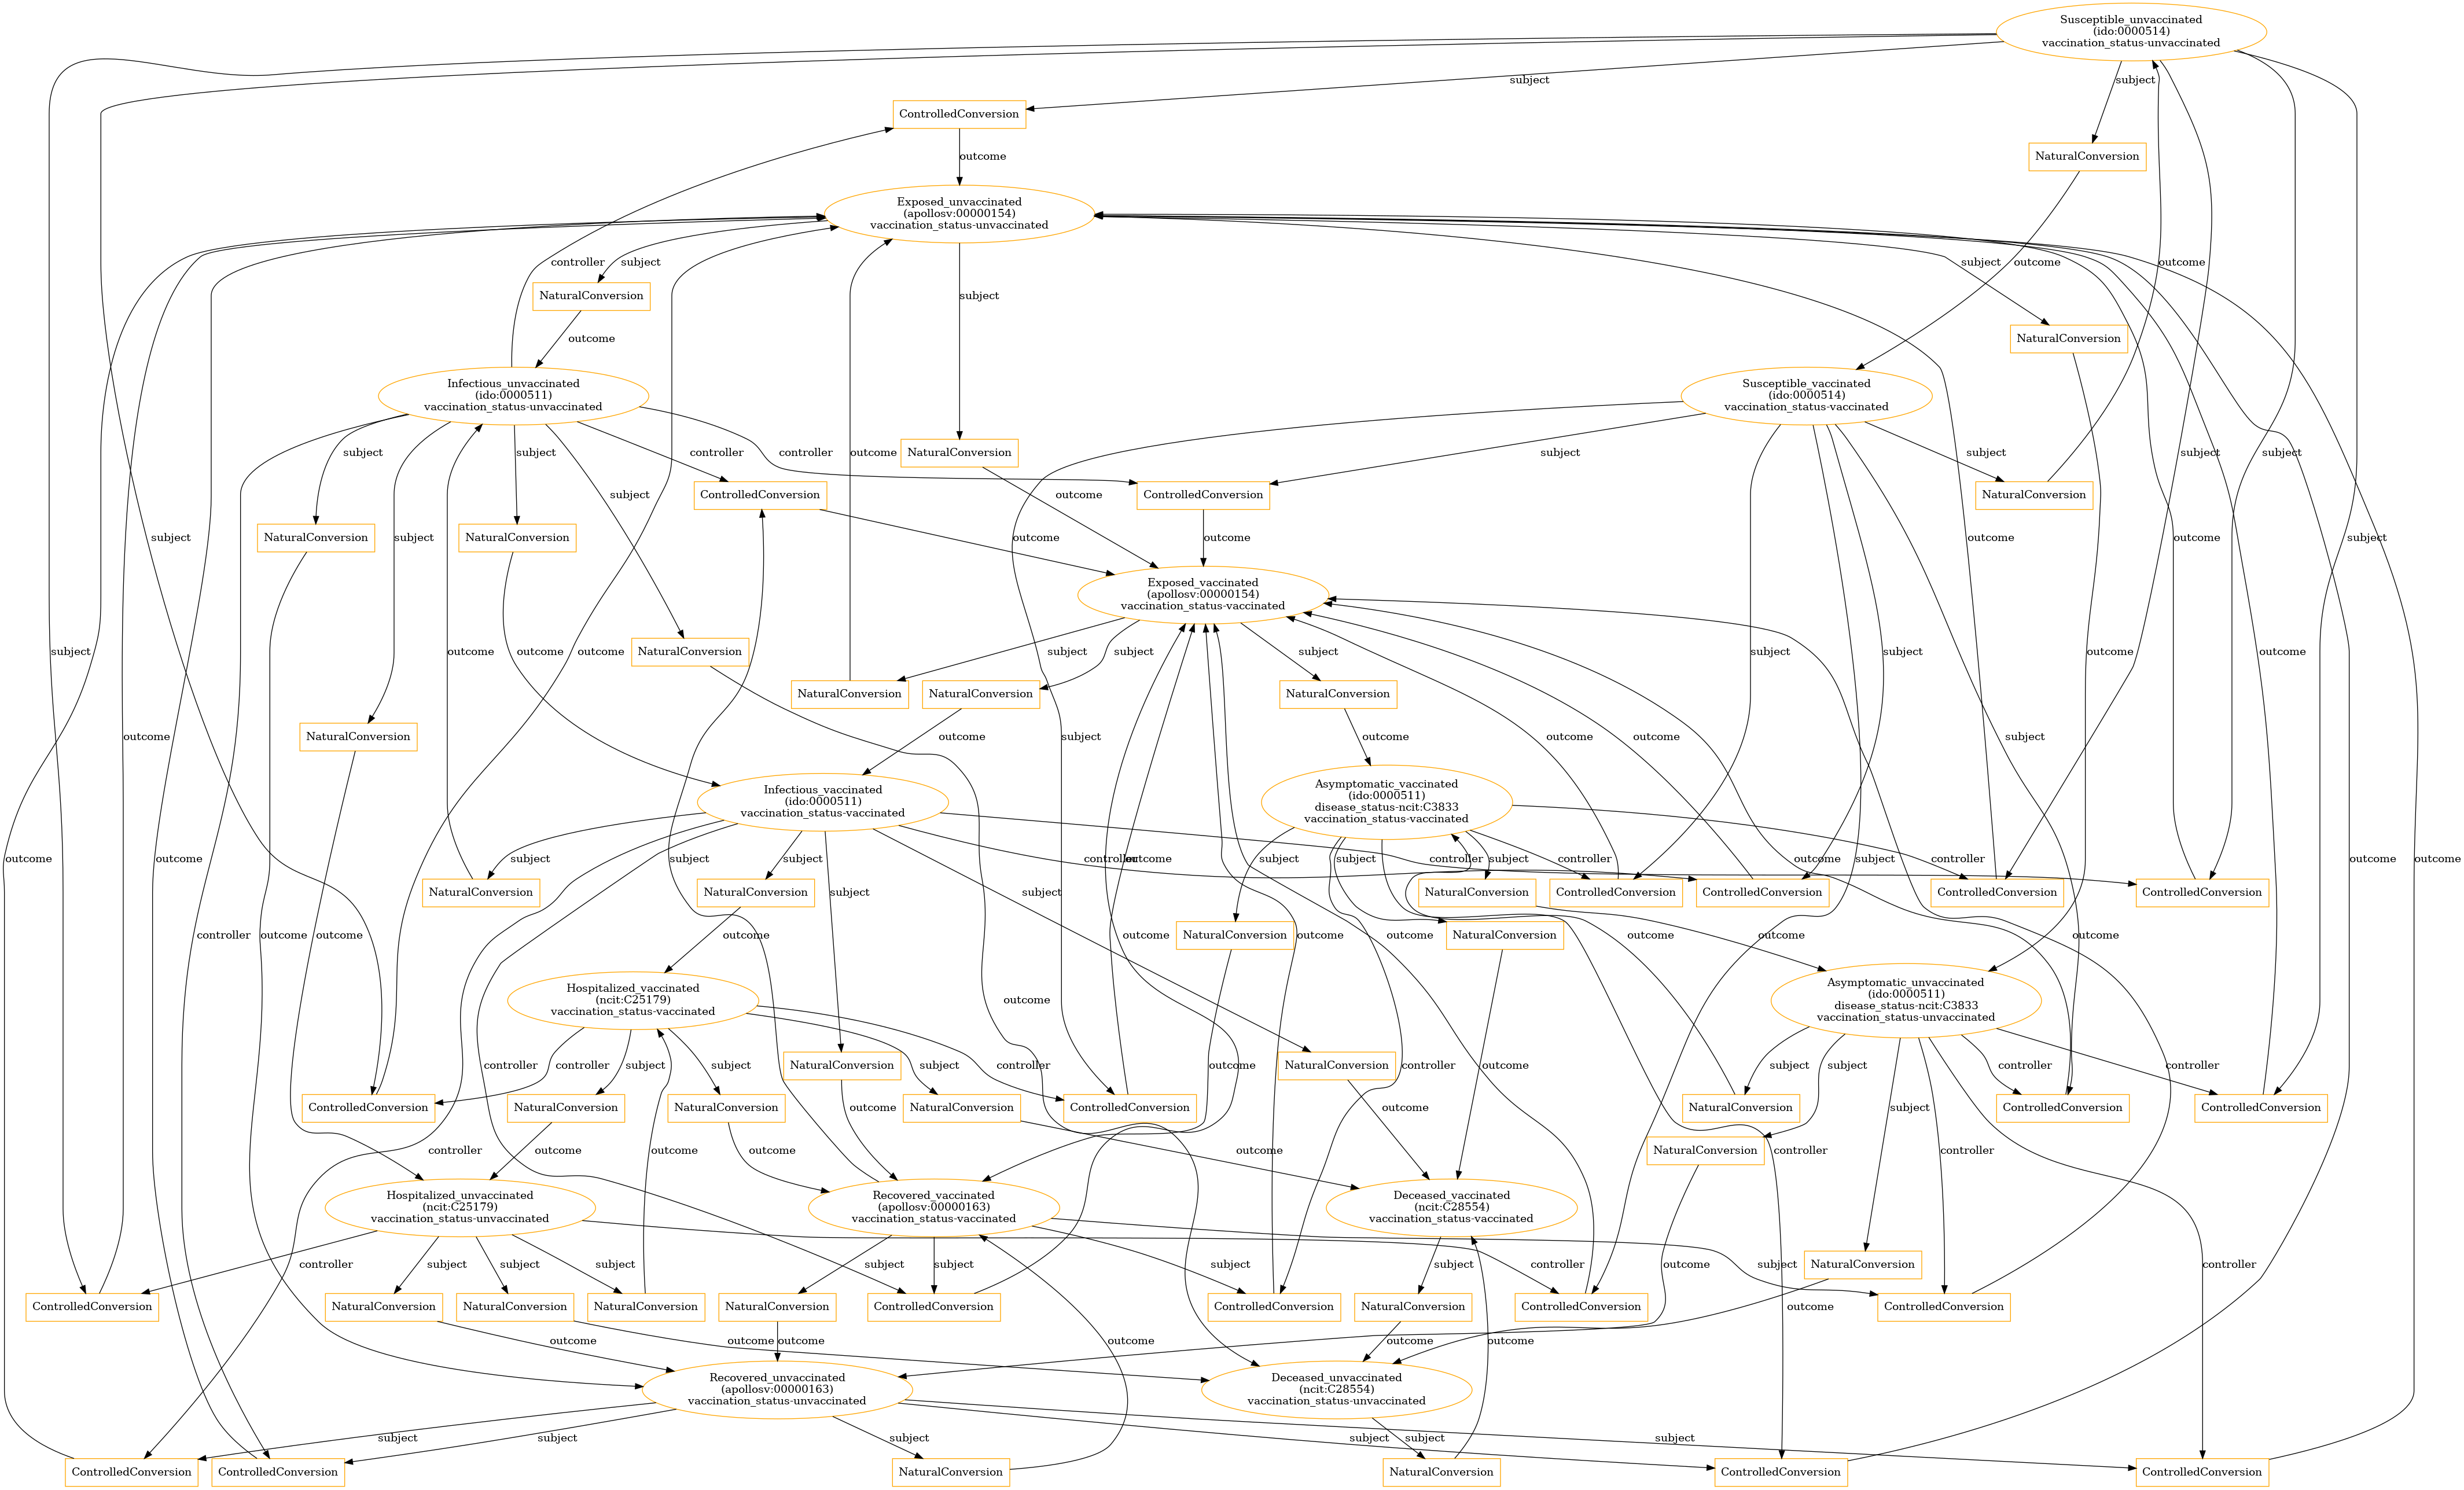

In [56]:
model_960_vaccination_reinfection.draw_graph("scenario3_model_960_vaccination_reinfection.png")
Image(filename="scenario3_model_960_vaccination_reinfection.png")

In [58]:
# Now compare the models again
tm_reinfection = TemplateModelDelta(template_model1=model_958_vaccination_reinfection,
                                    template_model2=model_960_vaccination_reinfection,
                                    refinement_function=is_ontological_child_web)
tm_reinfection.draw_graph("scenario3_model_958_960_delta_reinfection.png")
Image("scenario3_model_958_960_delta_reinfection.png")

ConnectionError: ('Connection aborted.', TimeoutError(110, 'Connection timed out'))